<a href="https://colab.research.google.com/github/xychong/edgeaimonitoring/blob/main/Quantization_Aware_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this QAT, we are using uint8 input and output tensors. All operations are compiled to the Edge TPU. There are no operations running on the CPU.

In [ ]:
#! pip uninstall -q -y tensorflow
! pip install tensorflow==2.6.0
! pip install keras==2.6.0
#! pip install -q tf-nightly
! pip install -q tensorflow-model-optimization
#! pip install numpy --upgrade

In [ ]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3
import os
import tempfile
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
from google.colab import files

# Keras imports 
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout,
                                     Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D)
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Accuracy

In [ ]:
print(tf.__version__)

2.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_data.npy", allow_pickle = True)
test_data = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_data.npy", allow_pickle = True)
train_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/train_label.npy", allow_pickle = True)
test_label = np.load("/content/drive/MyDrive/FYP Data/Train and Test/test_label.npy", allow_pickle = True)

In [ ]:
#model = tf.keras.models.load_model('/content/drive/MyDrive/FYP/mobilenetv2.h5')
#model = tf.keras.models.load_model('/content/drive/MyDrive/FYP/mobilenetv2_NEW.h5')
#model = tf.keras.models.load_model('/content/drive/MyDrive/FYP/mobilenetv2_NEW1.h5')
#model = tf.keras.models.load_model('/content/drive/MyDrive/FYP/mobilenetv2_NEW2.h5')
model = tf.keras.models.load_model('/content/drive/MyDrive/FYP/mobilenetv2_NEW3.h5')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
test_loss, test_acc = model.evaluate(test_data, test_label)

print("Tested Acc:", test_acc)

16/16 [==============================] - 16s 932ms/step - loss: 0.1552 - accuracy: 0.9440
Tested Acc: 0.9440000057220459


### Clone and fine-tune pre-trained model with quantization aware training

In [ ]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

opt = Adam(learning_rate=0.00001) # use a lower learning rate to prevent overfitting quickly
q_aware_model.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

q_aware_model.summary()

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3           input_1[0][0]                    
__________________________________________________________________________________________________
quant_Conv1 (QuantizeWrapperV2) (None, 112, 112, 32) 929         quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_bn_Conv1 (QuantizeWrapper (None, 112, 112, 32) 129         quant_Conv1[0][0]                
______________________________________________________________________________________________

In [ ]:
q_training = q_aware_model.fit(train_data, train_label, epochs= 10, validation_data=(test_data, test_label), verbose=1)

Epoch 1/10
63/63 [==============================] - 419s 6s/step - loss: 0.6823 - accuracy: 0.7710 - val_loss: 0.3788 - val_accuracy: 0.8540
Epoch 2/10
63/63 [==============================] - 411s 7s/step - loss: 0.3518 - accuracy: 0.8725 - val_loss: 0.2690 - val_accuracy: 0.9020
Epoch 3/10
63/63 [==============================] - 415s 7s/step - loss: 0.2329 - accuracy: 0.9180 - val_loss: 0.1986 - val_accuracy: 0.9340
Epoch 4/10
63/63 [==============================] - 418s 7s/step - loss: 0.1641 - accuracy: 0.9455 - val_loss: 0.1886 - val_accuracy: 0.9260
Epoch 5/10
63/63 [==============================] - 444s 7s/step - loss: 0.1315 - accuracy: 0.9555 - val_loss: 0.1678 - val_accuracy: 0.9260
Epoch 6/10
63/63 [==============================] - 434s 7s/step - loss: 0.1079 - accuracy: 0.9655 - val_loss: 0.1969 - val_accuracy: 0.9100
Epoch 7/10
63/63 [==============================] - 431s 7s/step - loss: 0.0867 - accuracy: 0.9715 - val_loss: 0.1546 - val_accuracy: 0.9400
Epoch 8/10
63

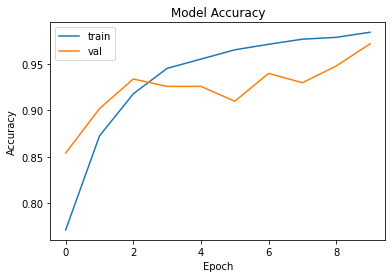

In [ ]:
plt.plot(q_training.history['accuracy'])
plt.plot(q_training.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

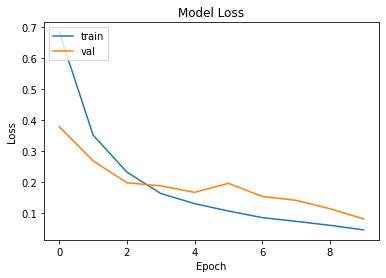

In [ ]:
plt.plot(q_training.history['loss'])
plt.plot(q_training.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
_, baseline_model_accuracy = model.evaluate(
    test_data, test_label, verbose=0)

_, q_aware_model_accuracy = q_aware_model.evaluate(
   test_data, test_label, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant test accuracy:', q_aware_model_accuracy)

Baseline test accuracy: 0.9440000057220459
Quant test accuracy: 0.972000002861023


### Create Quantized model for TFLite Backend

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

quantized_tflite_model = converter.convert()

In [ ]:
# 'wb': file is opened for writing in binary mode
with open('mobilenet_v2_sound_classification_qat.tflite', 'wb') as f:
  f.write(quantized_tflite_model)

### Compare accuracy

In [ ]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0] # for one input data
  tensor_index = input_details['index'] # tensor index in the interpreter
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = input

def classify_audio(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke() # invoke the interpreter; must set input size, allocate tensor and fill values before calling this
  output_details = interpreter.get_output_details()[0] # for one output data
  output = interpreter.get_tensor(output_details['index']) # obtains output tensor in numpy array
  top_1 = np.argmax(output) # obtain most probable output
  return top_1

In [ ]:
interpreter = tf.lite.Interpreter('mobilenet_v2_sound_classification_qat.tflite')
interpreter.allocate_tensors() # tflite pre-plans tensor allocations to optimize inference

In [ ]:
# Obtain tflite prediction outputs

tflite_pred = []
ground_truth = test_label

for i in range(len(test_data)):
  prediction = classify_audio(interpreter, test_data[i])
  tflite_pred.append(prediction)

print(tflite_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 0, 4, 3, 3, 3, 3, 3, 3, 0, 0, 3, 1, 2, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 

In [ ]:
# Computes the frequency with which prediction matches ground truth
tflite_acc = Accuracy()
tflite_acc(ground_truth, tflite_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.874>

In [ ]:
print("Quant TF Lite accuracy: {:.5%}".format(tflite_acc.result().numpy()))

Quant TF Lite accuracy: 87.40000%


In [ ]:
print('Quant TF test accuracy: {:.5%}'.format(q_aware_model_accuracy))

Quant TF test accuracy: 97.20000%


### Compare size of float TFLite model and quantized TFLite model

In [ ]:
# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
  f.write(quantized_tflite_model)

with open(float_file, 'wb') as f:
  f.write(float_tflite_model)

print("Float model in Mb:", os.path.getsize(float_file) / float(2**20))
print("Quantized model in Mb:", os.path.getsize(quant_file) / float(2**20))

INFO:tensorflow:Assets written to: /tmp/tmprh3t6tnp/assets


INFO:tensorflow:Assets written to: /tmp/tmprh3t6tnp/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Float model in Mb: 8.527118682861328
Quantized model in Mb: 2.60235595703125


### Compiling model for Edge TPU

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  93962      0 --:--:-- --:--:-- --:--:-- 93962
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-u

In [ ]:
# Compile model
! edgetpu_compiler mobilenet_v2_sound_classification_qat.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1259 ms.

Input model: mobilenet_v2_sound_classification_qat.tflite
Input size: 2.60MiB
Output model: mobilenet_v2_sound_classification_qat_edgetpu.tflite
Output size: 2.78MiB
On-chip memory used for caching model parameters: 2.71MiB
On-chip memory remaining for caching model parameters: 4.98MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: mobilenet_v2_sound_classification_qat_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


In [ ]:
! edgetpu_compiler -s mobilenet_v2_sound_classification_qat.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1193 ms.

Input model: mobilenet_v2_sound_classification_qat.tflite
Input size: 2.60MiB
Output model: mobilenet_v2_sound_classification_qat_edgetpu.tflite
Output size: 2.78MiB
On-chip memory used for caching model parameters: 2.71MiB
On-chip memory remaining for caching model parameters: 4.98MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: mobilenet_v2_sound_classification_qat_edgetpu.log

Operator                       Count      Status

DEPTHWISE_CONV_2D              17         Mapped to Edge TPU
PAD                            4          Mapped to Edge TPU
FULLY_CONNECTED                1          Mapped to Edge TPU
ADD                            10         Mapped to Edge TPU
MEAN                           1          Mapped to Edge TPU
QUANTIZE                  

### Download model compiled for Edge TPU

In [ ]:
files.download('mobilenet_v2_sound_classification_qat_edgetpu.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>